<a href="https://colab.research.google.com/github/JonMcEntee/hm-fashion-recommendations/blob/main/H%26M_Fashion_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 42

In [2]:
# Mount into drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# H&M Fashion Recommendations

This notebook details my approach to Kaggle's [H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview) competition, focused on predicting customers' next fashion purchases. With vast product selections becoming standard in retail, delivering precisely tailored suggestions is key to enhancing shopping experiences and brand loyalty in modern fashion commerce.

### **Data Loading and Preprocessing**

To optimize memory usage, I mapped customer and article IDs to integer indices, reducing the dataset size. Additionally, I converted transaction dates (`t_dat`) to datetime objects for easier time-based analysis.

In [123]:
articles = pd.read_csv("./drive/My Drive/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("./drive/My Drive/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = pd.read_csv("./drive/My Drive/h-and-m-personalized-fashion-recommendations/transactions_train.csv")\
  #.sample(frac=0.01, random_state=random_seed)

In [114]:
# Trick to reduce size in memory
customer_id_to_index_dict = dict(zip(customers["customer_id"], customers.index))
# customer_index_to_id_dict = dict(zip(customers.index, customers["customer_id"]))

transactions["customer_id"] = transactions["customer_id"].map(customer_id_to_index_dict)
customers["customer_id"] = customers["customer_id"].map(customer_id_to_index_dict)

article_id_to_index_dict = dict(zip(articles["article_id"], customers.index))
# article_index_to_id_dict = dict(zip(customers.index, articles["article_id"]))

transactions["article_id"] = transactions["article_id"].map(article_id_to_index_dict)
articles["article_id"] = articles["article_id"].map(article_id_to_index_dict)

transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

# Exploratory Data Analysis

To understand purchasing trends, I merged transaction data with article details (product type and group) and analyzed the distribution of sales across different product categories.  

**Key Findings:**
- **Upper-body clothing** (e.g., shirts, jackets) is the most popular product group.
- **Trousers** are the top-selling individual product type.  

This suggests that recommendations could benefit from emphasizing these high-demand categories while also exploring niche preferences for less common items.

In [116]:
article_details = pd.merge(transactions,
                           articles[["article_id",
                                     "product_type_name",
                                     "product_group_name"]],
                           how="left", on="article_id")

product_types = article_details.groupby("product_type_name")\
  .size()\
  .sort_values(ascending=False)\
  .reset_index(name='count')

product_groups = article_details.groupby("product_group_name")\
  .size()\
  .sort_values(ascending=False)\
  .reset_index(name='count')

del article_details

The bar plot below highlights the top 40 product types by sales volume. Trousers dominate, followed by other upper-body garments like T-shirts and sweaters. This insight can guide inventory prioritization and recommendation strategies.

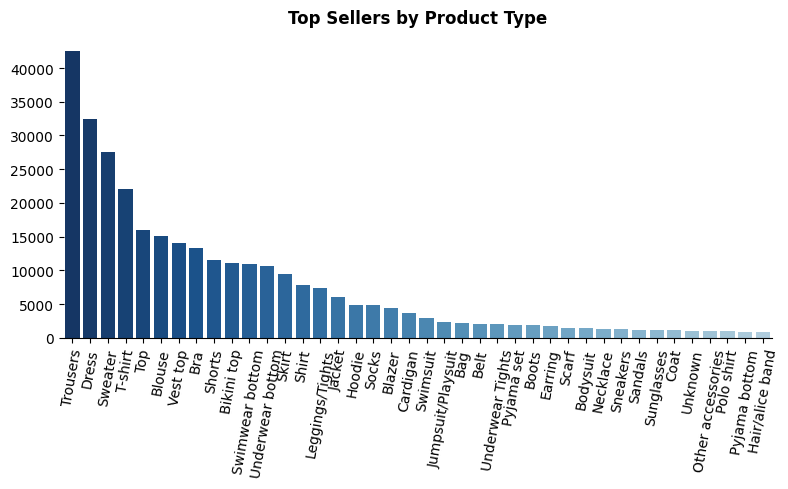

In [203]:
plt.figure(figsize=(8, 5))
num_categories=40
custom_palette = sns.color_palette('Blues', num_categories + 20)[20:][::-1]
g = sns.barplot(product_types.head(num_categories), x = "product_type_name", y = "count", hue="product_type_name", palette=custom_palette)
g.tick_params(axis='x', labelrotation=80, labelsize=10);
g.set_xlabel("")
g.set_ylabel("")
g.set_title("Top Sellers by Product Type", fontweight='bold', pad=10)
sns.despine(left=True)
plt.tight_layout()

In [227]:
product_groups

,product_group_name,count
0,Garment Upper body,125335
1,Garment Lower body,70820
2,Garment Full body,35558
3,Underwear,25762
4,Swimwear,25626
5,Accessories,15897
6,Shoes,7408
7,Socks & Tights,6812
8,Nightwear,3537
9,Unknown,996


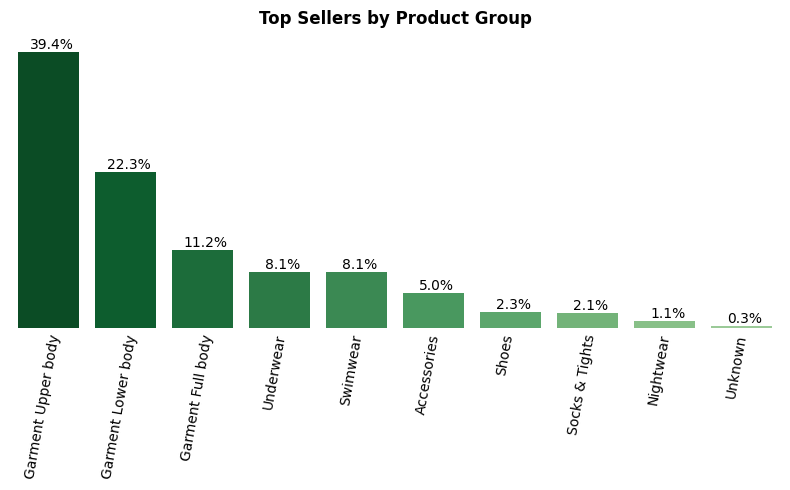

In [229]:
plt.figure(figsize=(8, 5))
num_categories=10
custom_palette = sns.color_palette('Greens', num_categories + 6)[6:][::-1]
g = sns.barplot(product_groups.head(num_categories), x = "product_group_name", y = "count", hue="product_group_name", palette=custom_palette)

total = product_groups['count'].sum()

for p in g.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    g.text(p.get_x() + p.get_width()/2. + 0.04,
           height,
           percentage,
           ha='center',
           va='bottom',
           fontsize=10)

g.tick_params(axis='x', labelrotation=80, labelsize=10, size=0);
shift_amount = -0.07
new_xticks = [x + shift_amount for x in g.get_xticks()]
g.set_xticks(new_xticks)

g.set_xlabel("")
g.set_ylabel("")
g.set_title("Top Sellers by Product Group", fontweight='bold', pad=10)
g.axes.yaxis.set_visible(False)
sns.despine(left=True, bottom=True)
plt.tight_layout()

Purchase volume over time appears relatively stable, showing no clear upward or downward trend.

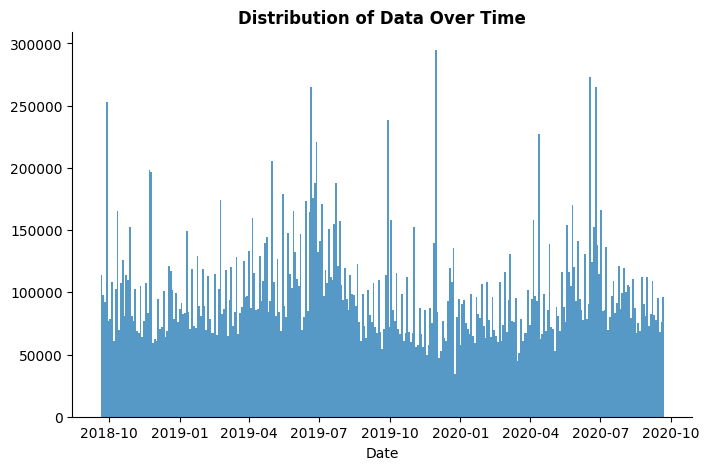

In [111]:
plt.figure(figsize=(8, 5))
g = sns.histplot(transactions,
                 x = "t_dat",
                 edgecolor=None,
                 bins=100)

g.set_ylabel('', labelpad=0)
g.set_xlabel("Date")
g.set_title("Distribution of Data Over Time", fontweight="bold");
# g.tick_params(axis='x', labelrotation=80, labelsize=10);

sns.despine()

The majority of customers in the dataset have made at least one purchase, enabling the development of personalized recommendation models based on past behavior. However, for customers with limited or no transaction history, cold-start strategies (e.g., demographic-based or popularity-based recommendations) will be essential to provide meaningful suggestions.

In [165]:
transaction_count = transactions\
  .groupby("customer_id")\
  .size()\
  .reset_index(name="count")\
  .groupby("count")\
  .size()\
  .reset_index(name="customers")

no_transactions = customers[
    ~customers["customer_id"].isin(transactions["customer_id"])]

transaction_count = pd.concat([
      pd.DataFrame([{
          "count": 0,
          "customers": len(no_transactions)
      }]),
      transaction_count
    ],
    ignore_index=True
)

bins = [0, 1, 2, 3, 5, 10, 50, 100, 200, np.inf]
labels = ['0', '1', '2', '3-4', '5-9', '10-49', '50-99', '100-199', '200+']

transaction_count['count_bin'] = pd.cut(transaction_count['count'],
                                        bins=bins,
                                        labels=labels,
                                        right=False,
                                        include_lowest=True)

transaction_bins = transaction_count.groupby('count_bin', observed=True)['customers'].sum().reset_index()

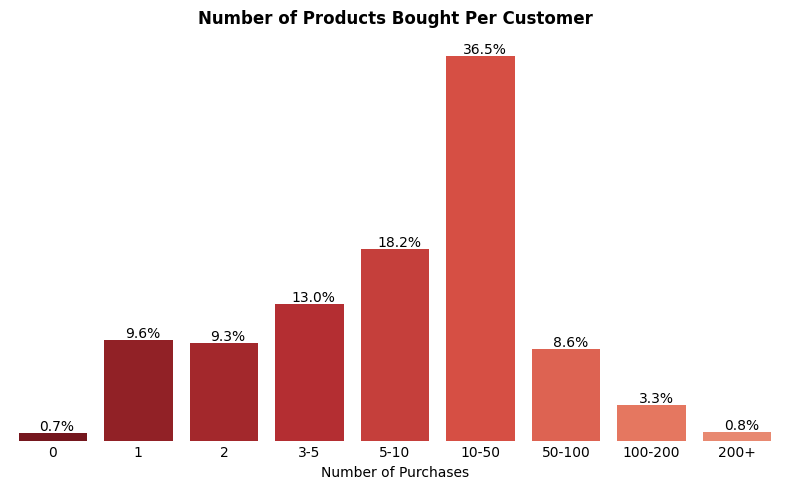

In [212]:
plt.figure(figsize=(8, 5))
num_categories=len(transaction_bins)
custom_palette = sns.color_palette('Reds', num_categories + 6)[6:][::-1]
g = sns.barplot(transaction_bins,
                x = "count_bin",
                y = "customers",
                hue="count_bin",
                palette=custom_palette)
g.tick_params(axis='x', labelsize=10, length=0);

total = transaction_bins['customers'].sum()

for p in g.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    g.text(p.get_x() + p.get_width()/2. + 0.05,
           height,
           percentage,
           ha='center',
           va='bottom',
           fontsize=10)

g.axes.yaxis.set_visible(False)
g.set_xlabel("Number of Purchases")
g.set_ylabel("Number of Customers")
g.set_title("Number of Products Bought Per Customer", fontweight='bold', pad=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()

 Analysis of the customer age distribution indicates a clear skew toward younger demographics. This trend may reflect H&M’s brand positioning and marketing efforts and should be considered when tailoring recommendation strategies to align with customer preferences.

In [177]:
age_count = customers.groupby("age").size().reset_index(name="count")

bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, np.inf]
labels = ['16-19', '20-24', '25-29', '30-34', '34-39', '40-44', '45-49',
          '50-54', '55-59', '60-64', '65-69', '70-74', '75+']

age_count["bin"] = pd.cut(age_count["age"],
                          bins=bins,
                          labels=labels,
                          right=False,
                          include_lowest=True)

age_bin = age_count.groupby('bin', observed=True)['count'].sum().reset_index()

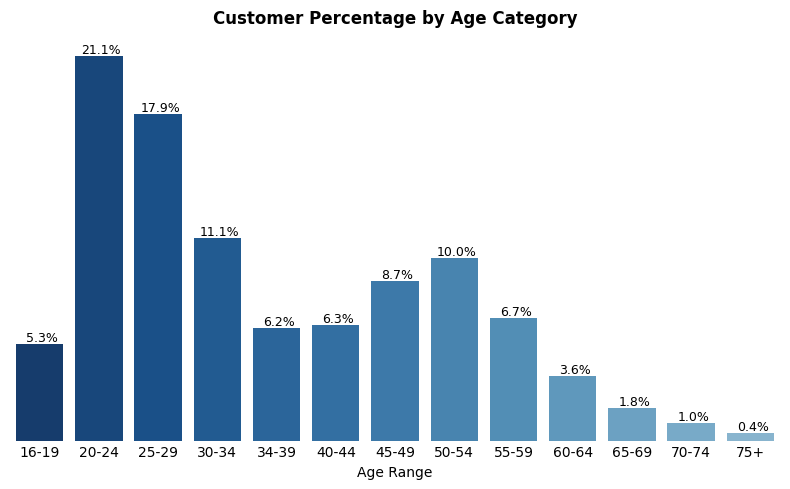

In [231]:
plt.figure(figsize=(8, 5))
num_categories=len(age_bin)
custom_palette = sns.color_palette('Blues', num_categories + 10)[10:][::-1]
g = sns.barplot(age_bin,
                x = "bin",
                y = "count",
                hue="bin",
                palette=custom_palette)
g.tick_params(axis='x', labelsize=10, length=0);

total = age_bin['count'].sum()

for p in g.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    g.text(p.get_x() + p.get_width()/2. + 0.04,
           height,
           percentage,
           ha='center',
           va='bottom',
           fontsize=9)

g.axes.yaxis.set_visible(False)
g.set_xlabel("Age Range")
g.set_ylabel("Number of Purchases")
g.set_title("Customer Percentage by Age Category", fontweight='bold', pad=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()

This age-related trend extends to purchasing behavior, where younger customers also account for a higher percentage of total transactions. Models may benefit from age-group segmentation to enhance prediction accuracy by capturing generational shopping patterns.

In [239]:
customer_purchases = pd.merge(transactions,
                              customers,
                              how="left", on="customer_id")

bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, np.inf]
labels = ['16-19', '20-24', '25-29', '30-34', '34-39', '40-44', '45-49',
          '50-54', '55-59', '60-64', '65-69', '70-74', '75+']

customer_purchases["bin"] = pd.cut(customer_purchases["age"],
                                   bins=bins,
                                   labels=labels,
                                   right=False,
                                   include_lowest=True)

purchase_bin = customer_purchases.groupby('bin', observed=True).size().reset_index(name="count")

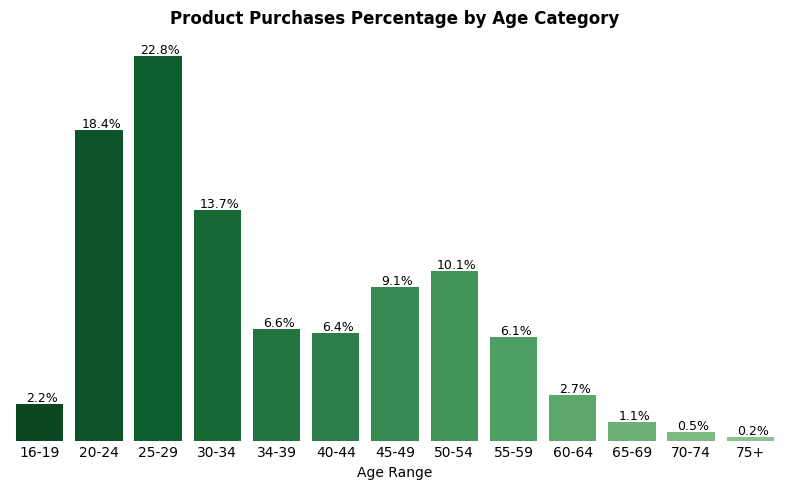

In [244]:
plt.figure(figsize=(8, 5))
num_categories=len(purchase_bin)
custom_palette = sns.color_palette('Greens', num_categories + 10)[10:][::-1]
g = sns.barplot(purchase_bin,
                x = "bin",
                y = "count",
                hue="bin",
                palette=custom_palette)
g.tick_params(axis='x', labelsize=10, length=0);

total = purchase_bin['count'].sum()

for p in g.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    g.text(p.get_x() + p.get_width()/2. + 0.04,
           height,
           percentage,
           ha='center',
           va='bottom',
           fontsize=9)

g.axes.yaxis.set_visible(False)
g.set_xlabel("Age Range")
g.set_ylabel("Number of Purchases")
g.set_title("Product Purchases Percentage by Age Category", fontweight='bold', pad=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()